In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [4]:
# corpus["message"].duplicated()
# corpus_doublons = corpus[corpus.duplicated(["message"], keep=False)]
corpus.sort_values("message").reset_index(drop=True)

NameError: name 'corpus' is not defined

In [5]:
path = PureWindowsPath(os.getcwd() + "\\data\\input\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus["category_bin"] = np.select([corpus["category"] == "philosophy"], [1], default=0)
corpus = corpus.sample(frac=1).reset_index(drop=True)
# corpus["category_bin"] = (corpus["category_bin"] == "philosophy")
# corpus

#preprocessing qui aurait du etre fait avant :
#enlever les retours a la ligne
corpus.replace("\\n", " ", regex=True, inplace=True)

#supprimer les doublons
print("corpus.shape =", corpus.shape)
corpus.drop_duplicates("message", inplace=True, keep="first")
print("corpus.shape =", corpus.shape)

# corpus.shape = (4007, 6) si False
# corpus.shape = (4649, 6) si first


corpus.shape = (8228, 6)
corpus.shape = (4649, 6)


In [6]:
zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())

(1824, 6)
1    1824
0    1824
Name: category_bin, dtype: int64


In [7]:
corpus

,id,message,message_preprocessed,category,length,category_bin
0,0,"Que nous ayons un amour ardent. « Quel plus grand motif y a-t-il de la venue du Seigneur que de nous montrer son amour pour nous? » « Si nous avons tardé à l’aimer, maintenant au moins ne tardons pas à lui rendre amour pour amour »",amour ardent « quel plus grand motif a-t-il venue seigneur montrer amour » « si tardé aimer maintenant moins tardons rendre amour amour »,philosophy,231,1
1,1,"_Mais si l’on comprend qu’il a demandé de ne pas boire la coupe de la mort et de la Passion, ou de ne pas la recevoir des Juifs, ce qu’il demandait ne s’est pas réalisé parce que la raison qui présentait cette demande ne voulait pas son accomplissement. Mais il voulait, pour nous instruire, nous faire connaître sa volonté de nature et le mouvement de sensualité qu’il avait comme homme._",si comprend a demandé boire coupe mort passion recevoir juif demandait réalisé parce raison présentait cette demande voulait accomplissement voulait instruire faire connaître volonté nature mouvement sensualité comme homme,philosophy,389,1
2,2,"Que 1000000 baptistes se trompent, ne crédibilise en rien un pédo-baptême qui n’existe pas.",baptiste trompent crédibilise rien pédo-baptême existe,baptism,91,0
3,3,"> Nous lisons dans Boèce : « Tout être, sous le rapport où il est être, est > un. » Mais, dans notre foi, nous attribuons l’être au Christ. Donc le Christ > est un.",lisons boèce « tout être sou rapport où être » foi attribuons être christ donc christ,philosophy,164,1
4,4,Le baptême a-t-il un fondement différent chez les enfants et chez les adultes ?,baptême a-t-il fondement différent chez enfant chez adulte,baptism,79,0
...,...,...,...,...,...,...
3643,3643,"Qu’est-ce que la prédestination, et introduit-elle quelque chose de réel dans le prédestiné ? Non, elle n’est réelle qu’en Dieu, les élus ne sont pas de nature différente du reste de l’humanité.",quest-ce prédestination introduit-elle quelque chose réel prédestiné non réelle dieu élu nature différente reste humanité,philosophy,194,1
3644,3644,"Nous reconnaissons que les bénéfices du baptême (ou de la Cène et de la Parole) nous viennent par la foi et qu’il n’y a pas de bénéfices spirituels en dehors d’elle. Mais cela ne veut pas dire que le baptême n’est pas une réalité objective. Pour le dire simplement, ce n’est pas parce que le rocher n’est pas amolli par la pluie que la pluie ne tombe pas sur lui. Au contraire, ce qui se passe dans les Sacrement est si objectif que celui qui les prend indignement est jugé. Ceux qui étaient circoncis de chair et non de cœur étaient jugés plus sévèrement que s’ils ne l’avaient pas été.",reconnaissons bénéfice baptême cène parole viennent foi a bénéfice spirituel dehors cela veut dire baptême réalité objective dire simplement parce rocher amolli pluie pluie tombe contraire passe sacrement si objectif celui prend indignement jugé ceux circoncis chair non cœur jugés plus sévèrement,baptism,587,0
3645,3645,"Dans l’institution de la cène qui dit ceci (1 Corinthiens 11.23-25; Matthieu 26.26-28; Marc 14.22-24; Luc 22.19s.): « _Le Seigneur Jésus, dans la nuit où il fut livré, prit du pain, et après avoir rendu grâce, il le rompit et dit: « Ceci est mon corps, qui est pour vous, faites cela en mémoire de moi. » Il fit de même pour la coupe, après le repas, en disant: « Cette coupe est la nouvelle alliance en mon sang; faites cela toutes les fois que vous en boirez, en mémoire de moi. Car toutes les fois que vous mangez ce pain et que vous buvez cette coupe, vous annoncez la mort du Seigneur, jusqu’à ce qu’il vienne. »_ Et cette promesse est aussi répétée par saint Paul quand il dit (1 Corinthiens 10.16s.): « _La coupe de bénédiction que nous bénissons n’est-elle pas la communion au sang de Christ? Le pain que nous rompons n’est-il pas la communion au corps de Christ? Puisqu’il y a un seul pain, nous sommes un seul corps; car tous nous participons à cet unique pain. »_",institution cène dit ceci corinthiens - 

In [8]:
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# y_train.value_counts()
# print(indices_train, indices_test)
# indices_test

In [9]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 

# Cross validation
#Methode version automatisee facile grace a la fonction RepeatedStratifiedKFold de sklearn
#Selection de modeles avec la k cross validation pour determiner le meilleur
#Modeles utilisés dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVM (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
pd.set_option("display.precision", 2)
scoring = ['accuracy', 'precision', 'recall', 'f1']
# scoring = ['accuracy']
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
# models.append(('MLPClassifier', MLPClassifier(max_iter=500)))
models.append(('SGDClassifier', SGDClassifier()))
models.append(('SVM', SVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
 
# evaluate each model in turn
results = []
names = []
num_iter = 2
for name, model in models:
    sum_test_accuracy = 0
    sum_test_f1 = 0
    sum_test_recall = 0
    sum_test_precision = 0
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(name)) #2: pour ignorer les info inutiles

[('test_accuracy', 0.9501), ('test_precision', 0.9515), ('test_recall', 0.949), ('test_f1', 0.9501)] (LR)
[('test_accuracy', 0.9047), ('test_precision', 0.8633), ('test_recall', 0.9629), ('test_f1', 0.9102)] (AdaBoostClassifier)
[('test_accuracy', 0.9288), ('test_precision', 0.9166), ('test_recall', 0.9441), ('test_f1', 0.9301)] (KNN)
[('test_accuracy', 0.9388), ('test_precision', 0.9307), ('test_recall', 0.949), ('test_f1', 0.9396)] (RandomForest)
[('test_accuracy', 0.9499), ('test_precision', 0.9465), ('test_recall', 0.9543), ('test_f1', 0.9502)] (SGDClassifier)
[('test_accuracy', 0.9552), ('test_precision', 0.9586), ('test_recall', 0.9523), ('test_f1', 0.9553)] (SVM)
[('test_accuracy', 0.8783), ('test_precision', 0.8832), ('test_recall', 0.8744), ('test_f1', 0.878)] (DecisionTreeClassifier)


In [245]:
# Learning curves du modele selectionne : performances du modele en fonction de la taille du trainset
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#Entrees
    #train_sizes (liste de float) : tailles du train en pourcentage 
    #cv_param : parametres de type kfold pour la cross validation
def get_learning_curve(model, X_train, y_train, cv_param, scoring, train_sizes, n_jobs=-1):
    # print("train_sizes =", 100 * train_sizes * len(y_train))
    train_sizes, train_scores, cv_scores = learning_curve(model, X_train, y_train, cv=cv_param, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    # learning_curve(AdaBoostClassifier(), X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    model_name = str(model)
    plt.figure()
    train_plot_label = scoring.capitalize() + " sur le trainset"
    cv_plot_label = scoring.capitalize() + " sur le cvset"
    title = scoring.capitalize() + " sur le trainset et sur le cvset en fonction de la taille du trainset pour " + model_name
    plt.plot(train_sizes, train_scores_mean, label=train_plot_label, color="b")
    plt.plot(train_sizes, cv_scores_mean, label=cv_plot_label, color="r")
    plt.title(title)
    plt.xlabel("Taille du trainset", fontsize=12)
    plt.ylabel(scoring.capitalize(), fontsize=12)
    plt.legend(loc="upper right")
    plt.show()

k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold 
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

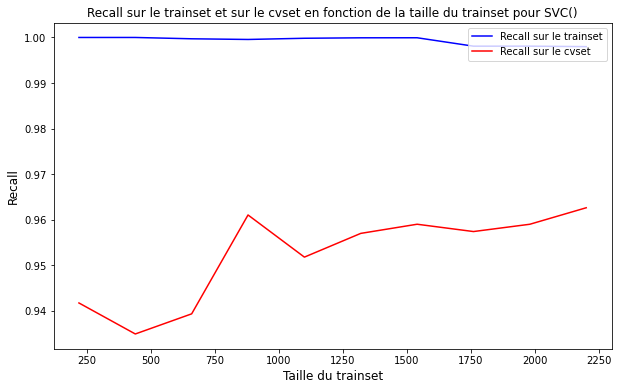

In [246]:
model = SVC() 
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "recall", train_sizes, n_jobs)

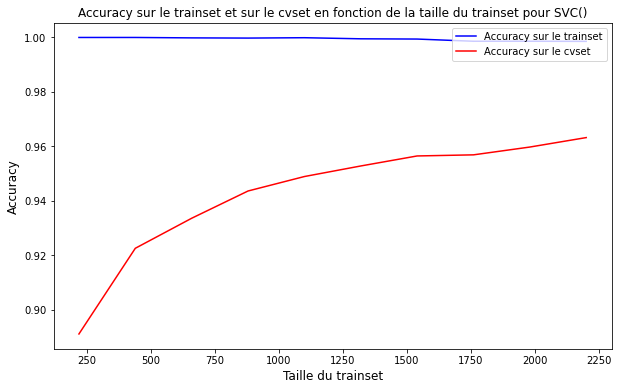

In [247]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "accuracy", train_sizes, n_jobs)

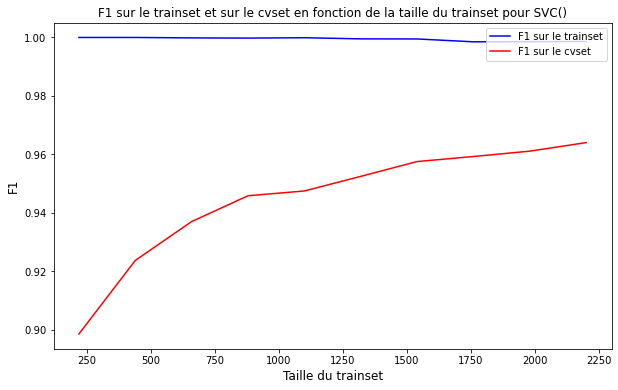

In [248]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "f1", train_sizes, n_jobs)

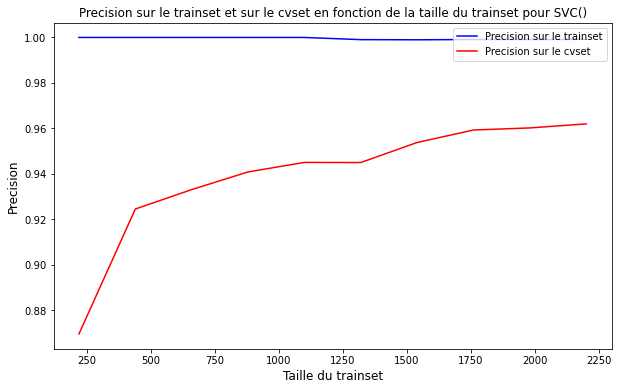

In [249]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "precision", train_sizes, n_jobs)

In [11]:
# entrainement du modele
# model = MultinomialNB()
model = SVC()
model.fit(X_train_tfidf, y_train)

SVC()

In [12]:
# test du modele
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = model.predict(X_test_tfidf)
print(y_pred)
print(X_test.shape)
print(X_test_tfidf.shape)

[1 1 0 ... 1 1 1]
(1204,)
(1204, 9494)


C:\Users\eupho\AppData\Local\Temp/ipykernel_8988/2510564835.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
C:\Users\eupho\AppData\Local\Temp/ipykernel_8988/2510564835.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


Text(69.0, 0.5, 'Catégories réelles')

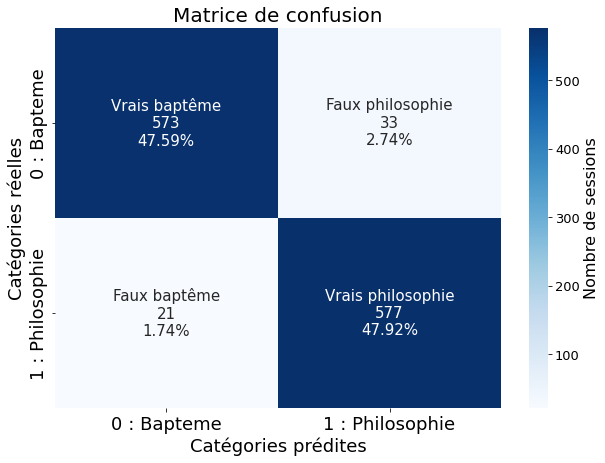

In [13]:
# Matrice de confusion
false_label = "0 : Bapteme"
true_label = "1 : Philosophie"
confusion_matrix_var = confusion_matrix(y_test, y_pred, labels=model.classes_)
group_names = ["Vrais baptême", "Faux philosophie", "Faux baptême", "Vrais philosophie"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_var.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_var.flatten()/np.sum(confusion_matrix_var)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
font_size = 15 #19
plt.rcParams["figure.figsize"] = (10, 7) #taille du graphique, taille du plot
ax = sb.heatmap(confusion_matrix_var, 
                annot=labels, fmt="", cmap='Blues',
                annot_kws={"size": font_size}, 
                cbar_kws={'label': 'Nombre de sessions'})
ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.figure.axes[-1].yaxis.label.set_size(font_size + 1)
ax.figure.axes[-1].tick_params(labelsize=font_size - 2) 
plt.title("Matrice de confusion", fontsize = font_size + 5)
# xlabel = 'Catégories prédites\n\n Exactitude (bien classés) = {:0.2f} % ; Inexactitude (mal classés) = {:0.2f} %\n Précision (bonnes prédictions de robots / qualité) = {:0.2f} %\n Rappel (nombre de robots détectés / quantité) = {:0.2f} %\n F1 (synthèse de précision + rappel) = {:0.2f} %'.format(accuracy, (100 - accuracy), precision, recall, f1_score)
plt.xlabel("Catégories prédites", fontsize=font_size + 3)
plt.ylabel("Catégories réelles", fontsize=font_size + 3)

In [14]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       606
           1       0.95      0.96      0.96       598

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



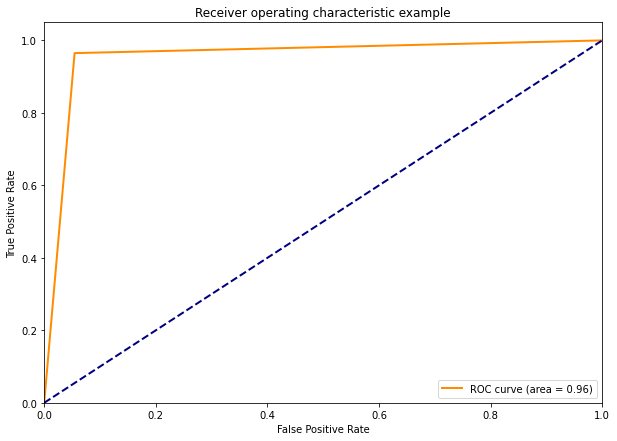

In [15]:
# Courbe ROC et AUC
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [16]:
# On affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"id":corpus.iloc[indices_test].id, "message": corpus.iloc[indices_test].message, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
print(corpus_test.shape)
print(corpus_test_errors.shape)
# corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
print(corpus_test_errors.columns)
corpus_test_errors = corpus_test_errors[["id", "truth", "pred", "message"]]
# corpus_test_errors

(1204, 4)
(54, 4)
Index(['id', 'message', 'truth', 'pred'], dtype='object')


In [17]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 1].id]) #aux philosophie

,id,message,message_preprocessed,category,length,category_bin
3156,3156,Q. 72: Le bain extérieur est-il donc en lui-même la purification des péchés?,q bain extérieur est-il donc lui-même purification péché,baptism,76,0
1114,1114,"=> « Incirconcis de cœur » ! Ça ne vous parles pas ? Cela montrent deux choses : – premièrement : Ils étaient circoncis mais pas de coeur. Cela veut dire qu’ils avaient un « esprit religieux », ils faisaient tout par tradition mais leurs cœurs n’étaient pas en Dieu. Alors cela déplu à Dieu. – deuxièmement : que Dieu n’a que faire des traditions et des religions, ce qu’Il attends de homme est un cœur entier, pur, qui aime Dieu et fasse Sa Volonté par L’Esprit-Saint !",« incirconcis cœur » ça parles cela montrent deux chose – premièrement circoncis coeur cela veut dire « esprit religieux » faisaient tout tradition leurs cœurs dieu alors cela déplu dieu – deuxièmement dieu a faire tradition religion attends homme cœur entier pur aime dieu fasse volonté esprit-saint,baptism,474,0
93,93,"Bien sûr, nous devons faire une évaluation un peu plus rigoureuse de l’origine de ce texte, et considérer qu’il pourrait s’agir d’un ensemble de points de vue attribués ultérieurement à des écoles rabbiniques antérieures. En suivant la méthodologie de Jacob Neusner, nous découvrirons que Hagigah 1:1 vient très probablement de la période de Yavneh de la formation de la Mishnah, qui est la première couche de la compilation, et la plus susceptible de représenter une vision exacte du judaïsme du premier siècle.",bien sûr devon faire évaluation peu plus rigoureuse origine texte considérer pourrait agir ensemble point vue attribués ultérieurement école rabbiniques antérieures suivant méthodologie jacob neusner découvrirons hagigah vient très probablement période yavneh formation mishnah première couche compilation plus susceptible représenter vision exacte judaïsme premier siècle,baptism,512,0
3576,3576,"Etudiant en maths/info, passionné par la théologie biblique qui me permet d'admirer la beauté et la cohérence de la Bible comme une seule grande histoire, par l'apologétique culturelle (l'analyse d'oeuvres culturelles, films/jeux/anime/littérature à la lumière de la foi) et par la philosophie thomiste pour ses riches apports en apologétique.",etudiant mathsinfo passionné théologie biblique permet admirer beauté cohérence bible comme seule grand histoire apologétique culturelle lanalyse oeuvre culturelles filmsjeuxanimelittérature lumière foi philosophie thomiste riche apport apologétique,baptism,343,0
2315,2315,"En attendant, vous pouvez consulter nos articles sur les [Alliances](https://parlafoi.fr/category/alliances/) et ceux sur les [Sacrements](https://parlafoi.fr/category/theologie/sacrements/).",attendant pouvez consulter article allianceshttpsparlafoifrcategoryalliances ceux sacrementshttpsparlafoifrcategorytheologiesacrements,baptism,191,0
2350,2350,"Pas en théorie. Pas juste pour faire beau sur le papier. La Bible est claire en vrai. On peut connaître ce qu’elle enseigne et savoir ce que Dieu veut ! C’était comme une nouvelle naissance pour moi de redécouvrir cette vérité. Peut-être que vous ne comprenez pas tellement comment j’ai pu douter de cela : ça s’est fait progressivement et, comme je l’ai dit, c’est venu du fait que je me sentais submergé par tous ces grands spécialistes qui n’étaient pas d’accord.",théorie juste faire beau papier bible claire vrai peut connaître enseigne savoir dieu veut comme nouvelle naissance redécouvrir cette vérité peut-être comprenez tellement comment pu douter cela ça fait progressivement comme dit venu fait sentais submergé tous grand spécialiste accord,baptism,466,0
2102,2102,"Bonjour, un article à venir prouve sans l’ombre d’un doute que Paul a pour but de faire un tel parallèle, je rejette donc votre proposition.",bonjour article venir prouve sans ombre doute paul a but faire tel parallèle rejette donc proposition,baptism,140,0
3509,3509,"Vous avez beaucoup à apprendre. Sortez de vo

In [18]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 0].id]) #faux bapteme

#faux exemples a enlever : commentaires, description auteur, texte anglais, references bibliographiques

,id,message,message_preprocessed,category,length,category_bin
650,650,"Quant à Turretin (et une bonne part de la tradition réformée avec lui), il est…. D’accord avec la conclusion !",quant turretin bonne part tradition réformée est… accord conclusion,philosophy,110,1
51,51,"A ceci, je réponds que non seulement le danger est à craindre, mais qu’il s’est très souvent – et très salement- réalisé. Les abus autour des images à la fin du moyen-âge sont la raison pour laquelle la Réforme a aussi violemment rejeté tout usage des images. Encore aujourd’hui, certaines pratiques laissent très perplexes tous les observateurs des romains au point où les évêques eux- mêmes reconnaissent cette possibilité d’abus.",a ceci réponds non seulement danger craindre très souvent – très salement- réalisé abus autour image fin moyen-âge raison laquelle réforme a aussi violemment rejeté tout usage image encore hui certaines pratique laissent très perplexes tous observateur romain point où évêque eux- même reconnaissent cette possibilité abus,philosophy,432,1
1729,1729,Etienne Omnès sur 23 septembre 2019 à 12 h 03 min,etienne omnès septembre heure min,philosophy,49,1
2889,2889,Luc-Laurent Salvador sur 13 septembre 2019 à 6 h 01 min,luc-laurent salvador septembre heure min,philosophy,55,1
3026,3026,"Pour la réponse à la même question, voilà ce qu’en dit Turretin :",réponse question voilà dit turretin,philosophy,65,1
2620,2620,"6. Pour un recensement utile de ces débats, voir AYRES, Lewis, _Nicaea and its Legacy: An Approach to Fourth Century Trinitarian Theology_ (Oxford, England: Oxford University Press, 2004).[↩]",recensement utile débat voir ayres lewis nicaea and its legacy an approach to fourth century trinitarian theology oxford england oxford university press ↩,philosophy,193,1
2426,2426,[Maxime N. Georgel](http://www.parlafoi.local) sur 18 décembre 2019 à 9 h 29 min,maxime georgelhttpwwwparlafoilocal décembre heure min,philosophy,80,1
175,175,### Objection 4 : Ce n’est pas conforme à l’enseignement des apôtres,objection conforme enseignement apôtre,philosophy,68,1
2178,2178,"Turretin consacre une question entière à ce sujet (ITE, vol 2, Sujet 11, Q8). Je ne reporte ici qu’un seul de ses arguments, la section 4 :",turretin consacre question entière sujet ite vol sujet q reporte ici seul argument section,philosophy,139,1
1747,1747,"De la même façon, l’abattage du gorille Harembe dans le zoo de Cincinnati n’est pas réalisé dans le but de tuer inutilement le gorille, mais pour sauver l’enfant qui était tombé entre ses mains. Ce qui était visé était non la mort du gorille, mais l’intégrité physique de l’enfant qui passait par cette voie. Il était possible de récupérer l’enfant sans déclencher soi-même aucun mal, mais dans ce cas l’enfant aurait été blessé, à moins que ce ne soit un gardien. Le bien supérieur dans cette situation était de tuer le gorille, mais cette mort n’était pas pour autant le but ou la volonté des soigneurs et ils ne sont donc pas responsables de sa mort.",façon abattage gorille harembe zoo cincinnati réalisé but tuer inutilement gorille sauver enfant tombé entre main visé non mort gorille intégrité physique enfant passait cette voie possible récupérer enfant sans déclencher soi-même aucun mal cas enfant blessé moins gardien bien supérieur cette situation tuer gorille cette mort autant but volonté soigneur donc responsable mort,philosophy,653,1


In [108]:
len(scores_tfidf) 

9494

In [112]:
# on affiche les poids des mots tfidf
idf = tfidf_vectorizer.idf_
scores_tfidf = pd.DataFrame({"id":range(len(words)), "words":tfidf_vectorizer.get_feature_names(), "idf":idf})
scores_tfidf = scores_tfidf.sort_values("idf", ascending=False)
print("moyenne des poids idf =", np.mean(scores_tfidf["idf"]))
print("ecart-type des poids idf =", np.std(scores_tfidf["idf"]))
with pd.option_context("display.max_rows", 100):
    display(scores_tfidf)

moyenne des poids idf = 7.522647894916232
ecart-type des poids idf = 0.8752806531998847


c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,id,words,idf
0,0,aaen,8.11
5200,5200,markus,8.11
5192,5192,marginalisation,8.11
5191,5191,marginalisant,8.11
5190,5190,marchons,8.11
...,...,...,...
3368,3368,fait,2.89
6301,6301,plus,2.78
9476,9476,être,2.72
1580,1580,comme,2.72


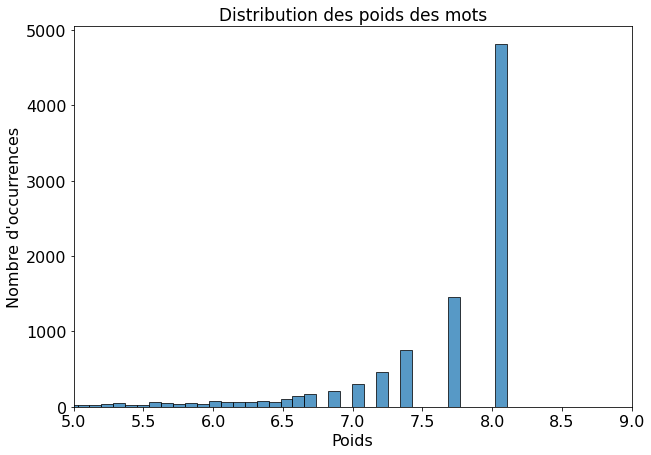

In [210]:
# Distribution des poids des mots (calcules avec sklearn)
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution.png")
path = path.as_posix()

sb.histplot(data=scores_tfidf, x="idf")
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids des mots", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(5, 9)
plt.savefig(path)
plt.show()

In [218]:
print(X_train_tfidf)

  (0, 938)	0.14975249720900632
  (0, 1278)	0.25881951747805343
  (0, 3032)	0.1805577109558408
  (0, 3463)	0.1717749918572689
  (0, 3470)	0.3565672217787948
  (0, 4353)	0.3487267720443616
  (0, 4924)	0.2730398314020285
  (0, 6101)	0.3359443558741422
  (0, 6294)	0.14220352245898796
  (0, 6866)	0.29284888401567827
  (0, 6914)	0.2714250213113555
  (0, 6942)	0.48235376469227026
  (1, 1234)	0.35278539324581504
  (1, 1390)	0.24876277255825688
  (1, 2886)	0.35278539324581504
  (1, 3114)	0.3060842688820331
  (1, 5701)	0.5153104755176197
  (1, 5881)	0.34568776370052984
  (1, 6695)	0.4587695715785898
  (2, 3891)	0.32471570121808185
  (2, 4851)	0.4255660813517386
  (2, 5029)	0.37569788041498425
  (2, 5324)	0.33644098458013805
  (2, 7771)	0.5059853025118624
  (2, 7922)	0.4506558154221349
  :	:
  (2444, 2987)	0.1285927656688988
  (2444, 3178)	0.18937453585490432
  (2444, 3463)	0.15774127795882753
  (2444, 3876)	0.16371815429440134
  (2444, 4968)	0.13233731891410083
  (2444, 5146)	0.1731871613594009


In [20]:
# Calcul manuel des poids
print("X_train_tfidf.shape =", X_train_tfidf.shape)
words_weights = X_train_tfidf.sum(axis=0)
print("words_weights.shape =", words_weights.shape)
print(words_weights)
print(words_weights.shape)

X_train_tfidf.shape = (2444, 9494)
words_weights.shape = (1, 9494)
[[0.18069121 0.47365002 0.14229562 ... 0.10828184 0.11174379 0.33523137]]
(1, 9494)


In [21]:
words_weights = np.ravel(words_weights)
print(words_weights)
print(words_weights.shape)

[0.18069121 0.47365002 0.14229562 ... 0.10828184 0.11174379 0.33523137]
(9494,)


In [26]:
# words_weights[:10]
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.unique(words_weights).shape
np.max(words_weights)
np.min(words_weights)
words_weights.shape
words_weights

array([0.181, 0.474, 0.142, ..., 0.108, 0.112, 0.335])

In [36]:
# scores_tfidf["manuel_weights"] = words_weights
print("corpus.shape =", corpus.shape)
print("scores_tfidf.shape =", scores_tfidf.shape)
scores_tfidf

corpus.shape = (3648, 6)
scores_tfidf.shape = (9494, 3)


,words,idf,manuel_weights
0,aaen,8.11,0.18
5200,markus,8.11,0.47
5192,marginalisation,8.11,0.14
5191,marginalisant,8.11,0.90
5190,marchons,8.11,0.18
...,...,...,...
3368,fait,2.89,6.29
6301,plus,2.78,0.14
9476,être,2.72,0.11
1580,comme,2.72,0.11


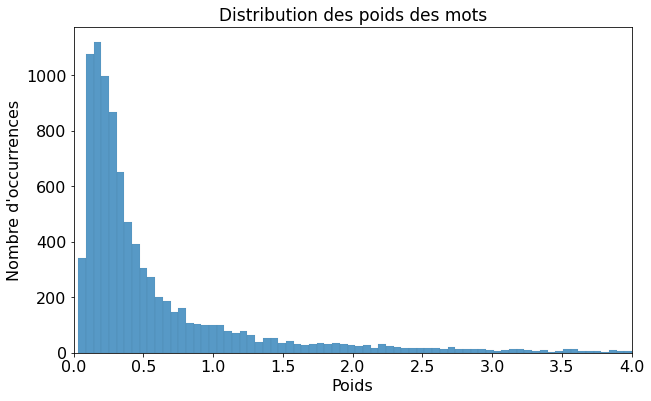

In [216]:
# Distribution des poids des mots (calcules avec a la main)
# Pour chaque phrase, y a-t-il beaucoup de mots qui ont ete trouves et qui ont influences positivement la prediction ?
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution_manuel.png")
path = path.as_posix()

# sb.histplot(words_weights[:100000])
sb.histplot(words_weights)
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids des mots", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 4)
plt.savefig(path)
plt.show()

In [223]:
import plotly.express as px
fig = px.histogram(words_weights,
                 width=700, height=500,)
fig.update_traces(marker_line_width=1,marker_line_color="white")
fig.show() #bizarre verifier pourquoi valeurs changent en fonction du nombre de couleur presente ?

In [284]:
# Mots les plus importants pour chaque exemple (texte)
X_train_tfidf.shape
print(X_train_tfidf)

  (0, 7553)	0.12736993072182626
  (0, 2973)	0.18420232922971116
  (0, 8688)	0.07769596222035731
  (0, 9288)	0.1451209918900519
  (0, 8808)	0.12523458042091834
  (0, 1284)	0.10056829494798189
  (0, 6570)	0.14870020689325986
  (0, 6034)	0.13918469907169115
  (0, 2204)	0.18420232922971116
  (0, 6321)	0.1462593734323282
  (0, 688)	0.16401043460055387
  (0, 8563)	0.21759421620077085
  (0, 5715)	0.22036347092439054
  (0, 4881)	0.15606756293006602
  (0, 1006)	0.12423016274777288
  (0, 6038)	0.18420232922971116
  (0, 629)	0.12575195898555064
  (0, 6229)	0.18991689453382707
  (0, 1300)	0.10852894472950503
  (0, 1804)	0.18420232922971116
  (0, 8353)	0.2134530740217521
  (0, 8799)	0.4153359114041054
  (0, 1445)	0.20562875885077825
  (0, 6483)	0.11319808455680858
  (0, 3073)	0.14298564158914395
  :	:
  (2444, 4731)	0.23726729932602028
  (2444, 2884)	0.21045706853589452
  (2444, 6547)	0.21045706853589452
  (2444, 1149)	0.21698614266264657
  (2444, 8762)	0.17831219575319612
  (2444, 6433)	0.14818602

In [104]:
# scores_tfidf.sort_index(inplace=True)
scores_tfidf


,words,idf
0,aaen,8.11
5200,markus,8.11
5192,marginalisation,8.11
5191,marginalisant,8.11
5190,marchons,8.11
...,...,...
3368,fait,2.89
6301,plus,2.78
9476,être,2.72
1580,comme,2.72


In [51]:
print(X_train_tfidf)

  (0, 540)	0.19922311655296568
  (0, 838)	0.11338218934236612
  (0, 1315)	0.1857414263565728
  (0, 1426)	0.0994965486065249
  (0, 1992)	0.2590139085079784
  (0, 2158)	0.3235260583123609
  (0, 2358)	0.2104879850367319
  (0, 2566)	0.09349270865326209
  (0, 3273)	0.214731644731936
  (0, 3771)	0.2590139085079784
  (0, 5620)	0.14454591719986595
  (0, 5998)	0.2823607933210237
  (0, 6356)	0.1946520604465617
  (0, 6603)	0.29762259455633333
  (0, 6802)	0.3029054211707166
  (0, 6804)	0.1946520604465617
  (0, 7812)	0.20455930867016056
  (0, 7896)	0.12931157869733712
  (0, 8304)	0.2460621766299646
  (0, 8618)	0.09331375635791654
  (0, 8619)	0.2409365180168398
  (0, 9228)	0.149841802811808
  (1, 1757)	0.18867038933464358
  (1, 2087)	0.38606941991303856
  (1, 3371)	0.2070404541068958
  :	:
  (2442, 2213)	0.21758767934673987
  (2442, 2358)	0.09207141146038665
  (2442, 2909)	0.34083795810915696
  (2442, 3470)	0.20938259892550903
  (2442, 4024)	0.17675817009110037
  (2442, 4065)	0.16241046303052797
  (

In [116]:
scores_tfidf.head()

,id,words,idf
0,0,aaen,8.11
5200,5200,markus,8.11
5192,5192,marginalisation,8.11
5191,5191,marginalisant,8.11
5190,5190,marchons,8.11


In [150]:
threshold_score = 4.5
col_top_words = [] #liste des top words pour chaque exemple du corpus (partie train)

In [151]:
# Exemple pour une seule ligne (un seul exemple)
#Return the indices and values of the nonzero elements of a matrix
from scipy.sparse import csr_matrix, find
# print("X_train_tfidf.shape =", X_train_tfidf.shape)
id_loc = 0 #id dans le ndarray X_train (qui correspond ligne a ligne a indices_train)
id_glob = indices_train.iloc[id_loc] #id dans le dataframe corpus
# print("id_exemple =", id_exemple)
extract = X_train_tfidf[:(id_loc + 1),:]
#  type(find(extract)[0])
_, words_indices, words_weights = find(extract)
# words_indices = [int(e) for e in words_indices]
# corpus.iloc[id_glob].message
df_best_words = scores_tfidf.iloc[words_indices].sort_values("idf", ascending=False).query("idf > @threshold_score")
df_best_words["words_with_score"] = df_best_words["words"] + " (" + df_best_words["idf"].round(2).astype(str) + ")"
df_best_words
top_words = list(df_best_words["words_with_score"])
top_words = ", ".join(word for word in top_words)
col_top_words.append(top_words)
# print(type(top_words))
print(col_top_words)

['convenir (8.11), glorifierai (8.11), suivie (7.7), exode (6.72), saurait (6.4), appartient (6.24), possède (6.09), puissant (6.09), créature (5.06), puissance (4.74), âme (4.69), propre (4.66), nom (4.53)']


In [123]:
scores_tfidf.sort_values("words", inplace=True) #remet les lignes dans l'ordre alphabetique (ordre par defaut)
# print(list(scores_tfidf.iloc[words_indices].words))
threshold_score = 4.5
with pd.option_context("display.max_rows", 1000):
    # display(scores_tfidf.iloc[words_indices].sort_values("idf", ascending=False))
    display(scores_tfidf.iloc[words_indices].sort_values("idf", ascending=False).query("idf > @threshold_score"))

,id,words,idf
1992,1992,convenir,8.11
3771,3771,glorifierai,8.11
8304,8304,suivie,7.70
3273,3273,exode,6.72
7812,7812,saurait,6.40
540,540,appartient,6.24
6356,6356,possède,6.09
6804,6804,puissant,6.09
2158,2158,créature,5.06
6802,6802,puissance,4.74


In [155]:
print(len(X_train))
print((X_train.shape)[0])
print(indices_train.shape)

2444
2444
(2444,)


In [163]:
# scores_tfidf.sort_values("idf", ascending=False, inplace=True)
# scores_tfidf
scores_tfidf.iloc[words_indices].query("idf > @threshold_score")

,id,words,idf
5192,5192,marginalisation,8.11
5174,5174,manquant,8.11
5174,5174,manquant,8.11
5174,5174,manquant,8.11
5173,5173,manquait,8.11
...,...,...,...
9228,9228,âme,4.69
9228,9228,âme,4.69
9228,9228,âme,4.69
9228,9228,âme,4.69


In [167]:
import pprofile
profiler = pprofile.Profile()

ModuleNotFoundError: No module named 'pprofile'

In [166]:
# Exemple pour une seule ligne (un seul exemple)
#Return the indices and values of the nonzero elements of a matrix
from scipy.sparse import csr_matrix, find
# print("X_train_tfidf.shape =", X_train_tfidf.shape)

for id_loc in range(len(X_train)):
    print("etape = {} %".format(id_loc / len(X_train)))
    # id_loc = 0 #id dans le ndarray X_train (qui correspond ligne a ligne a indices_train)
    # id_glob = indices_train.iloc[id_loc] #id dans le dataframe corpus
    # print("id_exemple =", id_exemple)
    extract = X_train_tfidf[:(id_loc + 1),:]
    #  type(find(extract)[0])
    _, words_indices, words_weights = find(extract)
    # words_indices = [int(e) for e in words_indices]
    # corpus.iloc[id_glob].message
    df_best_words = scores_tfidf.iloc[words_indices].query("idf > @threshold_score")
    # df_best_words["words_with_score"] = df_best_words["words"] + " (" + df_best_words["idf"].round(2).astype(str) + ")"
    # df_best_words.assign(words_with_score=df_best_words.words + " (" + df_best_words.idf.round(2).map(str) + ")")
    df_best_words['words_with_score'] = [x + " (" + str(y) + ")" for x, y in zip(df_best_words['words'], df_best_words['idf'])]

    # df_best_words
    top_words = list(df_best_words["words_with_score"])
    top_words = ", ".join(word for word in top_words)
    col_top_words.append(top_words)
    # print(type(top_words))
    # print(col_top_words)

etape = 0.0 %
etape = 0.0004091653027823241 %
etape = 0.0008183306055646482 %
etape = 0.0012274959083469722 %
etape = 0.0016366612111292963 %
etape = 0.0020458265139116204 %
etape = 0.0024549918166939444 %
etape = 0.0028641571194762683 %
etape = 0.0032733224222585926 %
etape = 0.0036824877250409165 %
etape = 0.004091653027823241 %
etape = 0.004500818330605565 %
etape = 0.004909983633387889 %
etape = 0.005319148936170213 %
etape = 0.0057283142389525366 %
etape = 0.0061374795417348605 %
etape = 0.006546644844517185 %
etape = 0.006955810147299509 %
etape = 0.007364975450081833 %
etape = 0.007774140752864157 %
etape = 0.008183306055646482 %
etape = 0.008592471358428805 %
etape = 0.00900163666121113 %
etape = 0.009410801963993453 %
etape = 0.009819967266775777 %
etape = 0.010229132569558102 %
etape = 0.010638297872340425 %
etape = 0.01104746317512275 %
etape = 0.011456628477905073 %
etape = 0.011865793780687398 %
etape = 0.012274959083469721 %
etape = 0.012684124386252046 %
etape = 0.013093

KeyboardInterrupt: 